- Keras needs backend framework for ML. Default is TensorFlow

In [1]:
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr #To retrieve data from REST API using API Key and format as pandas dataframe, I used AlphaVantage API this time

In [3]:
endDate = dt.datetime.now()
startDate = dt.datetime(2018,3,30)
startDate, endDate

stock = ['MSFT']

df = pdr.DataReader(stock, "av-daily-adjusted", startDate, endDate, api_key = 'API_KEY') #Reading daily adjusted stock data from RESTful API

#Create a new df from only close since that's the only col necessary for LSTM. Date col is used as index so doesn't need to be accounted for

data = df[['close']].copy() 
data.head()

,close
2018-04-02,88.52
2018-04-03,89.71
2018-04-04,92.33
2018-04-05,92.38
2018-04-06,90.23


In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

[Text(0.5, 0, 'Timesteps in Days'), Text(0, 0.5, 'Price (USD)')]

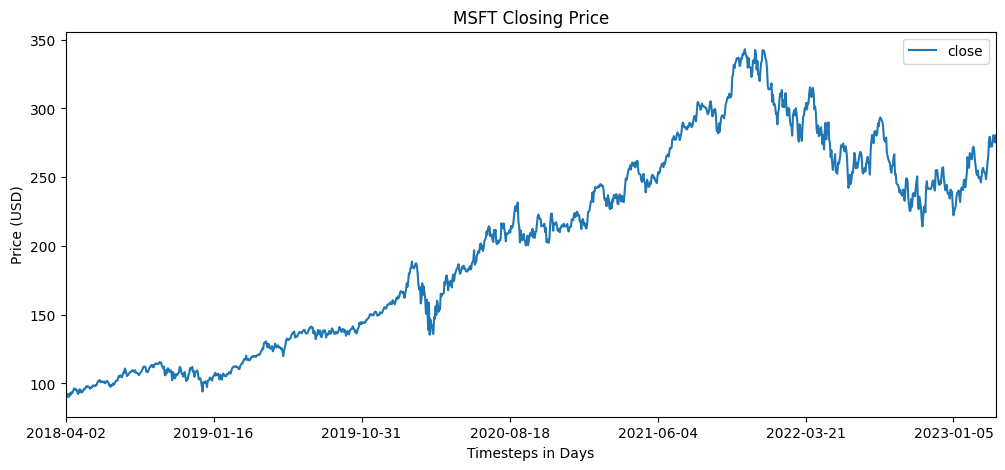

In [5]:
title = 'MSFT Closing Price'
ylabel='Price (USD)'
xlabel='Timesteps in Days' 

ax = data.plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [6]:
#scikit library allows access to multiple different data science processing tool
from sklearn.preprocessing import MinMaxScaler 

In [7]:
#Normalize (between 0 - 1) the data to eliminate large difference between price @ close over a long period of time, as I'm not interested in individual price like linear regression. Focus on the trend over time
scaler = MinMaxScaler() 
scaled_data = scaler.fit_transform(data) 
print(scaled_data)

[[0.        ]
 [0.00467418]
 [0.01496524]
 ...
 [0.7378923 ]
 [0.73337523]
 [0.75411446]]


In [8]:
train_data, valid_data, test_data = np.split(scaled_data,[int(.6*len(data)), int(.8*len(data))]) #60, 20, 20 split for train, valid, and test

In [9]:
print(len(train_data))
print(train_data[:10])

754
[[0.        ]
 [0.00467418]
 [0.01496524]
 [0.01516163]
 [0.00671668]
 [0.00883774]
 [0.01712557]
 [0.01311913]
 [0.01987509]
 [0.01791115]]


In [10]:
print(len(valid_data))
print(valid_data.shape)
print(valid_data[:10])

252
(252, 1)
[[0.56298362]
 [0.57838093]
 [0.6042264 ]
 [0.63062178]
 [0.62586904]
 [0.63388193]
 [0.64704034]
 [0.65725284]
 [0.65748851]
 [0.66762245]]


In [11]:
print(len(test_data))
print(test_data[:10])

252
[[0.89119761]
 [0.88510939]
 [0.86330964]
 [0.86766959]
 [0.88946934]
 [0.8734043 ]
 [0.82870498]
 [0.83605012]
 [0.81876743]
 [0.77277191]]


In [12]:
def create_dataset(dataset, timestep=1): #timestep is how much data is being read as once, 1 is reading each value; meaning daily
    data_x, data_y = [], [] #x for input, y for output
    for i in range(len(dataset) - timestep - 1): #input close price, output close price of next day
        data_x.append(dataset[i:(i+timestep),0]) #0 for first member, i:i+1 means i to i+1; gets one member at a time, current closing price
        data_y.append(dataset[i+timestep,0]) #next day's closing price
    return np.array(data_x), np.array(data_y)

In [13]:
timestep = 1 #range of data
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)
valid_x, valid_y = create_dataset(valid_data, timestep)

In [14]:
print(train_x.shape)

(752, 1)


In [15]:
print(valid_x.shape)

(250, 1)


In [16]:
print(test_x.shape)

(250, 1)


In [17]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1])) #shape: whatever the shape of training input, by 1 then by 1 again, creates another level of array, so each item in individual array within the matrix now becomes their own array
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
#makes it easier to train LSTM using this data format
print(train_x[:10])

[[[0.        ]]

 [[0.00467418]]

 [[0.01496524]]

 [[0.01516163]]

 [[0.00671668]]

 [[0.00883774]]

 [[0.01712557]]

 [[0.01311913]]

 [[0.01987509]]

 [[0.01791115]]]


In [18]:
#Keras is high level API used to build neural network for ml models, specialises towards deep neural networks, contains more abstract classes than tf hence easier to use
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [19]:
from keras.layers import Input, Dense, LSTM, TimeDistributed, Attention

In [20]:
model = Sequential() #Sequential ML model
model.add(LSTM(256, input_shape=(1,1))) 
#256 LSTM nodes/cells given pretty good results through trial and error, input is array of 1 by 1 hence why I reshaped train_x and test_x to an array within an array within a matrix
#adding thing sequentially
model.add(Dense(1, activation='linear')) #takes 1 output (close price) so only need one node, and activation is sigmoid function to end on
#tanh for input layer, sigmoid for output layer is superior  
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanSquaredError']) #mean squared error for loss function, adam optimizer, accuracy for model metrics
#change metrics from accuracy to correlation or absolute mean squared, for actual valuable analysis of data
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
model.fit(train_x, train_y, epochs=5, batch_size=1, verbose=1, validation_data=(valid_x, valid_y)) 
#fit function to train, epoch = 1 since it's LSTM sequential/RNN since it cycles through on its own, batch_size = 1 will pass in all data to train at once, verbose = 1 will print out actual value
score = model.evaluate(train_x, train_y, verbose=0) #verbose = 0 for extra info
print('Keras model loss on train test = ', score[0]) 
print('Keras model Mean Squared Error on train test = ', score[1]) 

score = model.evaluate(test_x, test_y, verbose=0) #verbose = 0 for extra info
print('Keras model loss on test set = ', score[0])
print('Keras model Mean Squared Error on test set = ', score[1])

Epoch 1/5
752/752 [==============================] - 5s 6ms/step - loss: 2.3013e-04 - mean_squared_error: 2.3013e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 2/5
752/752 [==============================] - 3s 4ms/step - loss: 2.3238e-04 - mean_squared_error: 2.3238e-04 - val_loss: 3.2351e-04 - val_mean_squared_error: 3.2351e-04
Epoch 3/5
752/752 [==============================] - 4s 5ms/step - loss: 2.4158e-04 - mean_squared_error: 2.4158e-04 - val_loss: 3.2436e-04 - val_mean_squared_error: 3.2436e-04
Epoch 4/5
752/752 [==============================] - 4s 5ms/step - loss: 2.2722e-04 - mean_squared_error: 2.2722e-04 - val_loss: 3.7848e-04 - val_mean_squared_error: 3.7848e-04
Epoch 5/5
752/752 [==============================] - 3s 4ms/step - loss: 2.0372e-04 - mean_squared_error: 2.0372e-04 - val_loss: 2.9294e-04 - val_mean_squared_error: 2.9294e-04
Keras model loss on train test =  0.0001688283373368904
Keras model Mean Squared Error on train test =  0.00016882833733689

In [23]:
train_predictions = model.predict(train_x) #convert result to readable data
test_predictions = model.predict(test_x)

8/8 [==============================] - 0s 3ms/step


In [24]:
train_predictions = scaler.inverse_transform(train_predictions) #scale input back to actual close values
train_y = scaler.inverse_transform([train_y]) #scale output back to actual close values

test_predictions = scaler.inverse_transform(test_predictions)
test_y = scaler.inverse_transform([test_y])

In [25]:
print(train_y.shape)
print(test_y.shape)
print(train_predictions.shape)
print(test_predictions.shape)

(1, 752)
(1, 250)
(752, 1)
(250, 1)


In [26]:
print(valid_data.shape)

(252, 1)


In [27]:
valid_predictions = scaler.inverse_transform(valid_data)
print(len(valid_predictions))
print(valid_predictions[:6])

252
[[231.85]
 [235.77]
 [242.35]
 [249.07]
 [247.86]
 [249.9 ]]


In [28]:
print(len(scaled_data)-len(train_predictions))

506


In [29]:
train_predict_plot = np.empty_like(scaled_data) #initialise an np array of empty values, pass in scaled data in the beginning as param
train_predict_plot[:,:] = np.nan #convert all vals to NaN, so it doesn't skew results if there are fewer values than size of array and there are unwanted values.
train_predict_plot[1:len(train_predictions)+1, :] = train_predictions #insert train predictions into plot

In [30]:
valid_predict_plot = np.empty_like(scaled_data) #initialise an np array of empty values, pass in scaled data in the beginning as param
valid_predict_plot[:,:] = np.nan #convert all vals to NaN, so it doesn't skew results if there are fewer values than size of array and there are unwanted values.
valid_predict_plot[(len(train_predictions)+2+1):len(train_predictions)+len(valid_predictions)+3, :] = valid_predictions #insert valid train predictions into plot

In [31]:
test_predict_plot = np.empty_like(scaled_data) #same as predict plot
test_predict_plot[:,:] = np.nan
test_predict_plot[(len(train_predictions)+len(valid_predictions)+3):len(scaled_data)-1, :] = test_predictions 
#len(train_predictions)+2+1 to len(scaled_data)-1, so taking it from index where train ended and test start; 70:30 of entire length

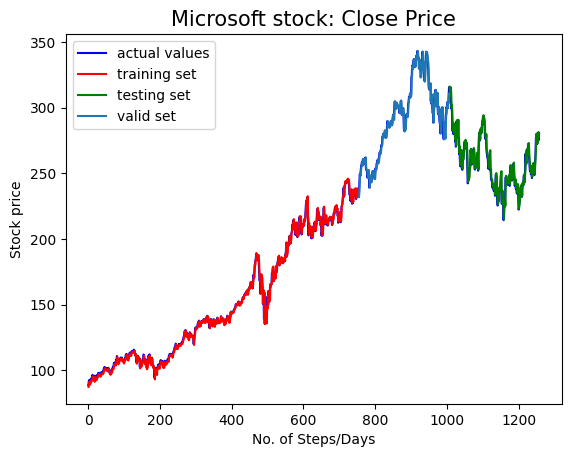

In [32]:
plt.plot(scaler.inverse_transform(scaled_data), "-b", label="actual values")
plt.plot(train_predict_plot, "-r", label="training set")
plt.plot(test_predict_plot, "-g", label="testing set")
plt.plot(valid_predict_plot, label="valid set")
plt.legend(loc="upper left")

plt.title('Microsoft stock: Close Price', fontsize=15)
plt.xlabel('No. of Steps/Days', fontsize=10)
plt.ylabel('Stock price', fontsize=10)

plt.show()

blue is scaled data, oranfe is train, green is predict. plots line by line of code.